## Cluster Analysis: FIBA vs NBA

In this notebook, we show our cluster analysis comparing play styles in the NBA and FIBA. Our approach is to use K-means clustering to cluster players from both leagues, and then analyze the way players map from cluster to cluster across different leagues. We use play type distributions parsed from the Synergy data as the features for our clustering. We also list some of our observations and next steps.

### Loading Data
We load two sheets with results from parsing the Synergy data for FIBA and NBA competitions, and merge the two dataframes. We remove any rows with fewer than 50 total plays.

In [29]:
import pandas as pd

# Load and format FIBA data
df_FIBA = pd.read_csv("FIBA_Play_Counts.csv", encoding='latin-1')
df_FIBA.rename(columns={"Unnamed: 0": "Player"}, inplace=True)
df_FIBA['Source'] = 'FIBA'

# Load and format NBA data
df_NBA = pd.read_csv("NBA_Play_Counts.csv", encoding='latin-1')
df_NBA.rename(columns={"Unnamed: 0": "Player"}, inplace=True)
df_NBA['Source'] = 'NBA'

# Concatenate datasets and filter out low-sample rows
df = pd.concat([df_FIBA, df_NBA])
df = df[df['Total'] >= 50].sort_values('Total', ascending=False)

s = df['Player'].value_counts()
print("Number of players from NBA:", sum(df['Source'] == 'FIBA'))
print("Number of players from FIBA:", sum(df['Source'] == 'NBA'))
print("Number of players in both:", int(len(df[df['Player'].isin(s[s>=2].index)])/2))
print("Total number of rows in dataframe:", len(df))
df.head(5)

Number of players from NBA: 1306
Number of players from FIBA: 986
Number of players in both: 164
Total number of rows in dataframe: 2292


,Player,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,Hand Off,Total,Source
156,James Harden,9932,1052,3056,7091,591,38,234,513,382,584,23473,NBA
29,Russell Westbrook,9795,1155,3599,3348,1625,17,273,920,196,411,21339,NBA
76,Damian Lillard,11599,1047,1596,2776,35,14,373,378,714,980,19512,NBA
121,DeMar DeRozan,7472,1395,1303,2731,1583,31,296,422,1398,644,17275,NBA
597,LeBron James,5781,758,2586,3629,2062,287,587,584,195,226,16695,NBA


Now, we convert the columns from play count totals to proportions, and prepare a dataframe to be passed into the clustering algorithm.

In [30]:
# Add columns for play type proportions
play_types = ['P&R Ball Handler', 'Spot-Up', 'Transition', 'ISO', 'Post-Up', 'P&R Roll Man', 'Cut', 'Offensive Rebound', 'Off Screen', 'Hand Off']
for p in play_types:
    df['% ' + p] = df[p] / df['Total']

# Make copy of columns for clustering
cluster_df = df[['% ' + p for p in play_types]].copy()
cluster_df.head()

,% P&R Ball Handler,% Spot-Up,% Transition,% ISO,% Post-Up,% P&R Roll Man,% Cut,% Offensive Rebound,% Off Screen,% Hand Off
156,0.423124,0.044817,0.130192,0.302092,0.025178,0.001619,0.009969,0.021855,0.016274,0.024880
29,0.459019,0.054126,0.168658,0.156896,0.076152,0.000797,0.012793,0.043114,0.009185,0.019261
76,0.594455,0.053659,0.081796,0.142271,0.001794,0.000718,0.019116,0.019373,0.036593,0.050226
121,0.432533,0.080753,0.075427,0.158090,0.091635,0.001795,0.017135,0.024428,0.080926,0.037279
597,0.346271,0.045403,0.154897,0.217370,0.123510,0.017191,0.035160,0.034981,0.011680,0.013537


## Clustering

We run K-means clustering for k (the number of clusters) between 5 and 15. We plot the inertia for each k. The inertia (also known as within-cluster sum-of-squares) measures how internally coherent each cluster is, with a lower inertia representing a better clustering model. See https://scikit-learn.org/stable/modules/clustering.html for more details.

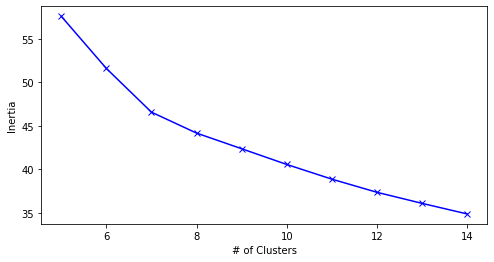

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Run model for various k values
inertias = []
for i in range(5, 15):
    test_model = KMeans(n_clusters=i)
    test_model.fit(cluster_df)
    inertias.append(test_model.inertia_)

# Plot inertias
plt.figure(figsize=(8,4))
plt.plot(range(5,15), inertias, 'bx-')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.show()

From this, we see using the elbow method that the best number of clusters is 7. Therefore, let us run the model with 7 clusters again and analyze its results.

In [47]:
# Run with 7 clusters and record results in dataframe column
num_clusters = 7
test_model = KMeans(n_clusters=num_clusters)
test_model.fit(cluster_df)
df['Cluster'] = test_model.labels_

# Show table with number of players in each cluster
tot_cluster_counts = df.groupby('Cluster')['Source'].size()
fiba_cluster_counts = df[df['Source'] == 'FIBA'].groupby('Cluster')['Source'].size()
nba_cluster_counts = df[df['Source'] == 'NBA'].groupby('Cluster')['Source'].size()
pd.DataFrame([fiba_cluster_counts, nba_cluster_counts, tot_cluster_counts], index = ['FIBA', 'NBA', 'Total']).transpose()

,FIBA,NBA,Total
Cluster,,,
0,185,118,303
1,266,145,411
2,105,158,263
3,220,196,416
4,148,49,197
5,212,161,373
6,170,159,329


# Analysis

To get a sense of the different clusters, let's print a few players from each cluster. We print the players with the highest total play counts so they are most likely to be players from the NBA that we would recognize. Keep in mind that these stats are from previous NBA seasons, and some players' styles may have changed since then.

In [10]:
for i in range(num_clusters):
    print("Cluster "+ str(i))
    print(list(df['Player'].loc[cluster_df[cluster_df['Cluster'] == i].head(15).index]))
    print()

Cluster 0
['Trevor Ariza', 'Jae Crowder', 'Danny Green', 'DeMarre Carroll', 'Robert Covington', 'PJ Tucker', 'Al Farouq Aminu', 'Wilson Chandler', 'Marvin Williams', 'Nikola Mirotic', 'CJ Miles', 'Jaylen Brown', 'Corey Brewer', 'Michael Kidd-Gilchrist', 'Allen Crabbe']

Cluster 1
['James Harden', 'Russell Westbrook', 'DeMar DeRozan', 'LeBron James', 'Stephen Curry', 'Bradley Beal', 'Kyle Lowry', 'Paul George', 'Jimmy Butler', 'CJ McCollum', 'Dwyane Wade', 'Andrew Wiggins', 'Eric Bledsoe', 'Gordon Hayward', 'Victor Oladipo']

Cluster 2
['LaMarcus Aldridge', 'Blake Griffin', 'DeMarcus Cousins', 'Nikola Vucevic', 'Marc Gasol', 'Karl-Anthony Towns', 'Al Horford', 'Brook Lopez', 'Enes Kanter', 'Zach Randolph', 'Dirk Nowitzki', 'Nikola Jokic', 'Pau Gasol', 'Dwight Howard', 'Jonas Valanciunas']

Cluster 3
['Damian Lillard', 'Kemba Walker', 'Chris Paul', 'John Wall', 'Kyrie Irving', 'Jeff Teague', 'Goran Dragic', 'Dennis Schroder', 'Isaiah Thomas', 'Jrue Holiday', 'Reggie Jackson', 'Mike Conle

We also print out the average play type proportions for each cluster.

In [11]:
cluster_df.groupby('Cluster').mean()

,% P&R Ball Handler,% Spot-Up,% Transition,% ISO,% Post-Up,% P&R Roll Man,% Cut,% Offensive Rebound,% Off Screen,% Hand Off
Cluster,,,,,,,,,,
0,0.079241,0.382503,0.168343,0.038302,0.034111,0.032552,0.068691,0.103880,0.060226,0.032153
1,0.432225,0.176983,0.136136,0.085589,0.013014,0.001482,0.026760,0.045584,0.043951,0.038276
2,0.003912,0.086202,0.065260,0.032295,0.353917,0.138294,0.142408,0.166633,0.008947,0.002133
3,0.605672,0.119397,0.093436,0.080554,0.004232,0.000547,0.013075,0.029394,0.022055,0.031638
4,0.003504,0.076687,0.080678,0.022221,0.127218,0.188631,0.224682,0.269028,0.004579,0.002772
5,0.235298,0.247162,0.175621,0.073041,0.024830,0.005739,0.042547,0.058802,0.087103,0.049856
6,0.022565,0.252347,0.112484,0.052800,0.143574,0.125400,0.113249,0.140737,0.026800,0.010044


These results generally make quite a lot of sense. Here are labels we came up with for the clusters, and the key play types for each.

0. Shooters: Spot-Up, Transition, Off Screen
1. Playmakers: Isolation, P&R Ball Handler, Spot-Up
2. Low-post bigs: Post-Up, Offensive Rebound, P&R Man
3. Ball handlers: P&R Ball Handler, Isolation, Spot-Up
4. Driving bigs: Offensive Rebound, Cut, P&R Man
5. Slasher: Off Screen, Transition, Hand-Off, Spot-Up, P&R Ball Handler
6. Stretch bigs: Spot-Up, Post-Up, Offensive Rebound

We notice that clusters 2, 4, and 6 contain more traditional big-men, and expect confusuion between these. Meanwhile, clusters 1, 3, and 5 are also similar, so we expect confusion between these.

We create a confusion matrix mapping players' clusters from NBA to FIBA, according to the format below:

| NBA\FIBA  | 0 | 1 | 2 |
|-----------|---|---|---|
| 0         | 5 | 2 | 0 |
| 1         | 1 | 8 | 3 |
| 2         | 0 | 4 | 6 |

For example, the confusion matrix above shows that 8 players were clustered into cluster 1 for both leagues, while 2 players are clustered in cluster 0 for their NBA stats but cluster 1 for their FIBA stats.

In [64]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Filter out players who are not in both FIBA and NBA records
s = df['Player'].value_counts()
names_to_keep = s[s >= 2].index
filt_df = df[df['Player'].isin(names_to_keep)]

# Create separate dataframes for NBA and FIBA records
nba_df = filt_df[filt_df['Source'] == 'NBA'].sort_values('Player')
fiba_df = filt_df[filt_df['Source'] == 'FIBA'].sort_values('Player')

# Ensure that filtered dataframes include exactly the same players
if False in nba_df['Player'].values == fiba_df['Player'].values:
    print("Some names do not match!")
else:
    print("All names match! Ready to create confusion matrix.\n")
    
# Create confusion matrix
cm = confusion_matrix(nba_df['Cluster'].values, fiba_df['Cluster'].values)
print("{:.2f}% of players stayed in the same cluster.".format(sum(np.diag(cm))/sum(sum(cm)) * 100))
pd.DataFrame(cm)

All names match! Ready to create confusion matrix.

54.88% of players stayed in the same cluster.


,0,1,2,3,4,5,6
0,14,0,5,0,4,0,1
1,0,13,0,8,0,4,0
2,2,0,16,0,12,0,0
3,3,2,0,14,1,3,4
4,1,0,1,0,8,0,0
5,0,10,0,1,0,18,0
6,5,0,0,7,0,0,7


Several observations:
- The number of players who stay in the same cluster is quite reasonable - a fair amount of players switch clusters, but not too many. This suggests that our model is capturing players' styles reasonably well, and that the number of clusters was appropriate.
- As expected, clusters 2 and 4, and clusters 1 and 5, show a lot of confusion. Interestingly, however, clusters 6 and 3 also show high confusion. This is very surprising as cluster 6 contains mostly centres, while cluster 3 contains mostly guards.
- Confusion is in some cases one-sided. That is, for example, many players who were clustered in cluster 2 in the NBA move to cluster 4 in FIBA. Likewise, many players in cluster 1 move to cluster 3, many in cluster 5 move to cluster 1, and many in cluster 6 move to clusters 3 or 0. This can be attributed to differences in the "global" play styles in FIBA vs. NBA. We take a deeper look at this below.

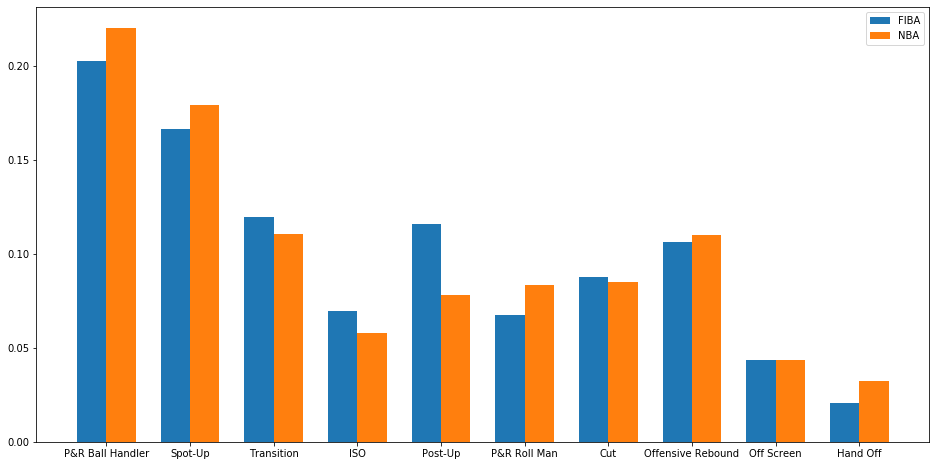

In [65]:
plt.figure(figsize = (16,8))
plt.bar([i for i in range(10)], fiba_df[['% ' + p for p in play_types]].mean(), width = 0.35)
plt.bar([i+0.35 for i in range(10)], nba_df[['% ' + p for p in play_types]].mean(), width = 0.35)
plt.xticks([i+0.175 for i in range(10)], play_types)
plt.legend(labels=['FIBA', 'NBA'])
plt.show()

From this chart, we see that post-up and isolation plays are more prevalent in FIBA compared to in the NBA, whereas the NBA sees more pick and roll actions and spot-ups.

Interestingly, this does not actually explain the patterns noticed above at all, since many players move to clusters with higher pick and roll rates in FIBA compared to in the NBA (e.g. 1 to 3, 5 to 1, 2 to 4).

One other factor that might be at play is that often, NBA players who represent their country at FIBA competitions will see a major increase in their role, as they are likely to be among the most skilled players on their nation's team. Hence, players who move from the NBA to FIBA are more likely to have the offence run through them or create shot opportunities for themselves. This can be seen in the list of players moving from clusters 6 to 3 or clusters 2 to 4, who may take on the role of a primary scorer in FIBA competition, but not in the NBA. Note that non of the players listed below are American.

In [97]:
def get_players_by_switch(nba_cluster, fiba_cluster):
    out = []
    fiba_set = set(fiba_df[fiba_df['Cluster'] == fiba_cluster]['Player'])
    for p in nba_df[nba_df['Cluster'] == nba_cluster]['Player'].values:
        out += [p] if p in fiba_set else []
    return out

print("Players switching from cluster 2 (NBA) to 4 (FIBA):")
for p in get_players_by_switch(2, 4):
    print(p)

print("\nPlayers switching from cluster 6 (NBA) to 3 (FIBA):")
for p in get_players_by_switch(6, 3):
    print(p)

Players switching from cluster 2 (NBA) to 4 (FIBA):
Alexis Ajinca
Anderson Varejao
Domantas Sabonis
Goga Bitadze
Gorgui Dieng
Gustavo Ayon
Jan Vesely
Jerome Jordan
Marcin Gortat
Miroslav Raduljica
Tiago Splitter
Zaza Pachulia

Players switching from cluster 6 (NBA) to 3 (FIBA):
Al-Farouq Aminu
Francisco Garcia
Josh Okogie
Nemanja Bjelica
Omri Casspi
Paul Zipser
Yuta Watanabe


Indeed, if we look at the players who switched from cluster 3 to 6 (the opposite as above), we see that three of the four players are American, and may actually see a reduction in their role importance at FIBA competition.

In [98]:
print("\nPlayers switching from cluster 3 (NBA) to 6 (FIBA):")
for p in get_players_by_switch(3, 6):
    print(p)

Players switching from cluster 4 (NBA) to 2 (FIBA):
Georgios Papagiannis

Players switching from cluster 3 (NBA) to 6 (FIBA):
Jaylen Brown
Joe Harris
Kostas Papanikolaou
Rudy Gay


## Next Steps

- Run a similar analysis with data from other club competitions to FIBA
- Run a combined analysis with both club and NBA data